In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy
from torch.nn.functional import pad
import torch.nn.init as init
import copy
from torch import autograd
from torchvision.utils import make_grid
from torch.optim import Adam
from torch.utils.data import DataLoader,TensorDataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
import functools

from generate_data import *
from network_class import *
from utils import utils


In [2]:

# a=torch.tensor(generate_2d(batch_size=10000,data_name="circles"))
# file_path = 'data/circles_2d.pt'
# torch.save(a, file_path)



In [3]:

device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

n_epochs =  1000#@param {'type':'integer'}
batch_size =  10000 #@param {'type':'integer'}
lr=4e-2 #@param {'type':'number'}
tspan=[0,1]
data_name="moon"
d=2
nt=8
h=(tspan[1]-tspan[0])/nt


# f_theta = torch.nn.DataParallel(velocity_net(d=2))
Phi = Phi(nTh=2, m=32, d=2 )

Phi = Phi.to(device)
optim = Adam(Phi.parameters(), lr=lr)
tqdm_epoch = tqdm.trange(n_epochs)

# data=torch.load('data/circles_2d.pt').float()
# label=torch.ones(data.shape[0],1)
# dataset = TensorDataset(data,label)
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)




  0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
def log_Gaussian(x,d):
    return -d/2*math.log(2*math.pi)-torch.sum(x**2,dim=1).reshape(-1,1)/2

def grad_log_Gaussian(x):
    return -x

In [5]:
def stepRK4(odefun, z, net,t0, t1):
    h = t1 - t0 # step size
    z0 = z
    K = h * odefun(z0, t0, net)
    z_temp = z0 + (1.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z_temp =z_temp+ (2.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z_temp = z_temp+(2.0/6.0) * K
    K = h * odefun( z0 + K , t0+h ,net)
    z_temp = z_temp+(1.0/6.0) * K
    return z_temp



def stepRK1(odefun, z, net,t0, t1):
    z0 = z
    z_temp =z0 + (t1 - t0) * odefun(z0, t0, net)

    return z_temp

def odefun(x, t, net):
    dx = net.trHess(x,t,justGrad=True)[:,0:d]
    return dx


def odefun_backward(cat_var, t, net):
    x=cat_var[:,0:d]
    score=cat_var[:,d+1:-1]
    


    divergence_f=torch.zeros(x.shape[0],device=device)
    
    # f=net(x, t).reshape(x.shape[0],-1)

    # #精确计算divergence_f
    # for i in range(d):
    #     grad = autograd.grad(f[:,i].sum(), x, create_graph=True)[0]
        
    #     divergence_f+= grad[:,i]

    # # 近似计算divergence_f
    # v=torch.randn(f.shape).to(device)
    # vf=torch.sum(f*v, dim=1)
    # a=autograd.grad(vf.sum(),x,create_graph=True)[0].reshape(x.shape[0],-1)
    # divergence_f=torch.sum(a*v, dim=1)

    #OT-Flow 手动计算
    gradPhi, trH = net.trHess(x,t)
    dx=gradPhi[:,0:d]
    divergence_f=trH
    d_log=-divergence_f.reshape(-1,1)




    
    
    #calculate jacobbian 
    jacobian = []
    grad_div_f=autograd.grad(divergence_f.sum(), x, create_graph=True,retain_graph=True)[0]
    
    for i in range(d):
        jacobian_i = autograd.grad(dx[:,i].sum(), x, create_graph=True,retain_graph=True)[0]
        # torch.autograd.functional.jacobian
        jacobian.append(jacobian_i)
    stacked_jacobbian = torch.stack(jacobian, dim=2)
    J_mul_f=torch.bmm(stacked_jacobbian,score.unsqueeze(2)).squeeze()
    d_score=(-grad_div_f-J_mul_f)
    # d_score=torch.zeros(x.shape[0],d).to(device)

    d_penalty=torch.mean(torch.sum((dx+score)**2,dim=1)*h)*torch.ones(x.shape[0],1).to(device)
    # d_penalty=torch.mean(torch.sum(dx**2,dim=1))*torch.ones(x.shape[0],1).to(device)  ##OT penalty
    


    
    return torch.cat((dx,d_log,d_score,d_penalty),dim=1)


In [6]:
llh_record=[]
v_pen_record=[]
x=torch.tensor(generate_2d(batch_size=batch_size,data_name=data_name)).float().to(device)

for epoch in tqdm_epoch:
    
    #resample
    if (epoch+1) %50==0:
        x=torch.tensor(generate_2d(batch_size=batch_size,data_name=data_name)).float()
        x = x.to(device)
         
         
    # zFull = torch.zeros(*x.shape , nt+1, device=x.device, dtype=x.dtype) # make tensor of size z.shape[0], z.shape[1], nt
    # zFull[:,:,0] = x
    z_temp=x
    tk=0
    for k in range(nt):
        tk=h*k
        z_temp = stepRK4(odefun, z_temp , Phi, tk, tk+h)
    z_terminal=z_temp
    



    log_terminal=log_Gaussian(x=z_terminal,d=d)
    log_temp=log_terminal
 
    score_terminal=grad_log_Gaussian(z_terminal)
    score_temp=score_terminal
    

    tk=tspan[1]
    z_back=z_terminal
    cat_var=torch.cat((z_back,log_temp,score_temp),dim=1)
    cat_var=pad(cat_var,(0,1,0,0),value=0)
 
    for k in  range(nt):
        
        # d_cat=odefun_score_log(cat_var, tk, net=Phi, device=device)
        cat_var= stepRK4(odefun_backward, cat_var , Phi, tk, tk-h)
        
        # log_temp=log_temp+(-h)*d_log.reshape(-1,1)
        # score_temp=score_temp+(-h)*d_score
        # bridge_pen+=torch.mean(torch.sum((f_theta(zFull[:,:,nt-k],tk)+score_temp)**2,dim=1)*h)
        tk-=h

    z,log_temp,bridge_pen=cat_var[:,0:d],cat_var[:,d],-cat_var[0,-1]



    optim.zero_grad()

    loss=-torch.mean(log_temp)*10  + bridge_pen
    # loss=-torch.mean(log_temp)*10
    loss.backward()
    optim.step()
    llh_record.append(-torch.mean(log_temp).detach().cpu())
    v_pen_record.append(bridge_pen.detach().cpu())
    tqdm_epoch.set_description('Loss: {:5f}'.format(-torch.mean(log_temp).detach().cpu()))
    torch.save(Phi.state_dict(), 'experiment/'+data_name+'_2d_OT.pth')
    if (epoch+1) % 200 == 0:
            for p in optim.param_groups:
                p['lr'] /= 2
            print("lr: ", p['lr'])
 



Loss: 2.537224:  20%|██        | 200/1000 [01:48<07:41,  1.73it/s]

lr:  0.02


Loss: 2.534204:  22%|██▏       | 215/1000 [01:58<07:12,  1.81it/s]


KeyboardInterrupt: 

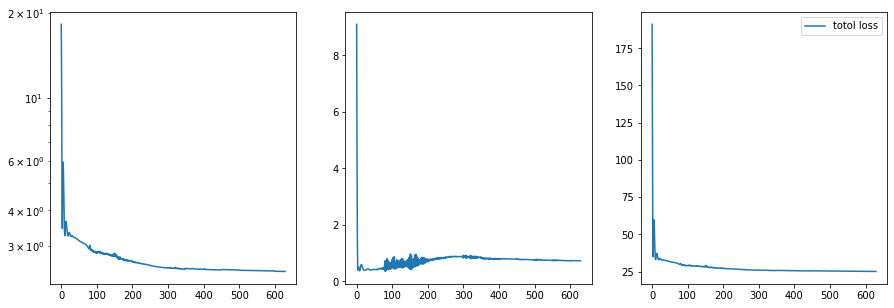

tensor(0.7207)


In [ ]:

from plot_tools import *



# plot_loss(llh_record)
plot_loss_all(llh_record,v_pen_record)
print(v_pen_record[-1])


In [ ]:
def plot_zfull(zFull):
    z=zFull.detach().cpu().numpy()
    fig, axs = plt.subplots(3, 3, figsize=(8, 8))
    axs[0,0].hist2d(z[:,0,0],z[:,1,0],bins=66, range=[[-4, 4], [-4, 4]])
    axs[0,1].hist2d(z[:,0,1],z[:,1,1],bins=66, range=[[-4, 4], [-4, 4]])
    axs[0,2].hist2d(z[:,0,2],z[:,1,2],bins=66, range=[[-4, 4], [-4, 4]])
    axs[1,0].hist2d(z[:,0,3],z[:,1,3],bins=66, range=[[-4, 4], [-4, 4]])
    axs[1,1].hist2d(z[:,0,4],z[:,1,4],bins=66, range=[[-4, 4], [-4, 4]])
    axs[1,2].hist2d(z[:,0,5],z[:,1,5],bins=66, range=[[-4, 4], [-4, 4]])
    axs[2,0].hist2d(z[:,0,6],z[:,1,6],bins=66, range=[[-4, 4], [-4, 4]])
    axs[2,1].hist2d(z[:,0,7],z[:,1,7],bins=66, range=[[-4, 4], [-4, 4]])
    axs[2,2].hist2d(z[:,0,8],z[:,1,8],bins=66, range=[[-4, 4], [-4, 4]])

    plt.tight_layout()
    plt.show()


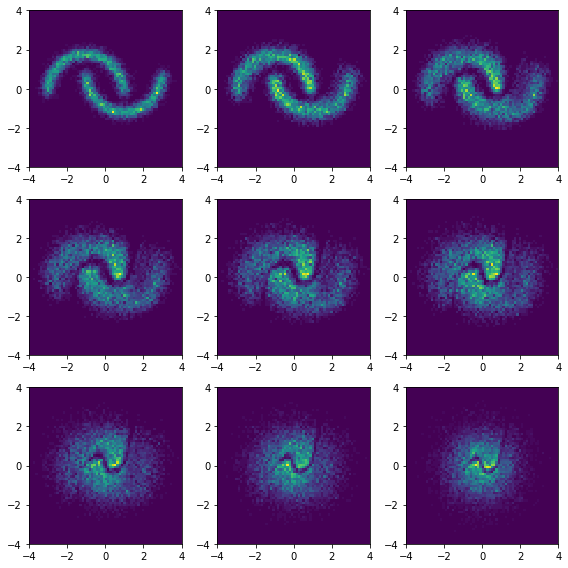

In [ ]:
# x=torch.load('SchB/data/circles_2d.pt').float().to(device)
x=torch.tensor(generate_2d(batch_size=10000,data_name=data_name)).float().to(device)
zFull = torch.zeros(*x.shape , nt+1, device=x.device, dtype=x.dtype) # make tensor of size z.shape[0], z.shape[1], nt
zFull[:,:,0] = x

tk=0
for k in range(nt):
    tk=h*k
    zFull[:,:,k+1] = stepRK4(odefun, zFull[:,:,k] , Phi, tk, tk+h)
    z=zFull.detach().cpu().numpy()


plot_zfull(zFull)




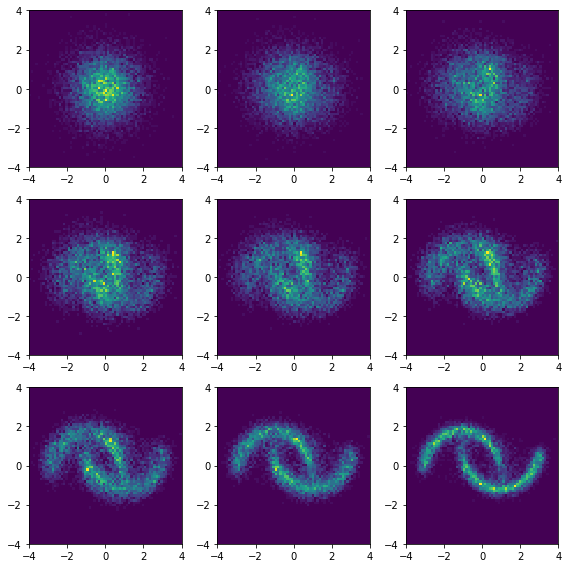

In [ ]:
x=torch.randn(10000,2).to(device)
zFull = torch.zeros(*x.shape , nt+1, device=x.device, dtype=x.dtype) # make tensor of size z.shape[0], z.shape[1], nt
zFull[:,:,0] = x
tk=0
for k in range(nt):
    tk=1-h*k
    zFull[:,:,k+1] = stepRK4(odefun, zFull[:,:,k] , Phi, tk, tk-h)

plot_zfull(zFull)